# Sentiment Analysis: Large Movie Review Dataset

### These are the objectives of the project:

* Read data.
* Put together a set of preprocessing functions that can be used later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* Train an own word embedding and use it as a vectorization source for the data.
* Train a sentiment analysis model that allows to detect positive and negative opinions in movie reviews.

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize.toktok import ToktokTokenizer
from gensim.models import Word2Vec
import numpy as np
import lightgbm as lgbm
import pickle
import text_normalizer
import evaluation

---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.


In [29]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]

path_test_pos = "aclImdb/test/pos"
path_test_neg = "aclImdb/test/neg"
path_train_pos = "aclImdb/train/pos"
path_train_neg = "aclImdb/train/neg"

i=0
for file in os.listdir(path_test_pos):
    if file.endswith('.txt'):
        with open (path_test_pos+'/'+file) as f:
            text  = f.read()
            X_test.append(text)
            y_test.append(1)

for file in os.listdir(path_test_neg):
    if file.endswith('.txt'):
        with open (path_test_neg+'/'+file) as f:
            text  = f.read()
            X_test.append(text)
            y_test.append(0)

for file in os.listdir(path_train_pos):
    if file.endswith('.txt'):
        with open (path_train_pos+'/'+file) as f:
            text  = f.read()
            X_train.append(text)
            y_train.append(1)

for file in os.listdir(path_train_neg):
    if file.endswith('.txt'):
        with open (path_train_neg+'/'+file) as f:
            text  = f.read()
            X_train.append(text)
            y_train.append(0)

---
## 2. Normalize the data

#### Create the following functions in another script called `text_normalizer.py`

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

In [4]:
from imp import reload 
reload(text_normalizer)
import text_normalizer

/tmp/ipykernel_23390/1280679861.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [6]:
X_train_norm=text_normalizer.normalize_corpus(
    X_train,
    html_stripping=True,
    contraction_expansion=True,
    accented_char_removal=True,
    text_lower_case=True,
    text_stemming=False,
    text_lemmatization=True,
    special_char_removal=True,
    remove_digits=True,
    stopword_removal=False
)

/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [25]:
X_test_norm=text_normalizer.normalize_corpus(
    X_test,
    html_stripping=True,
    contraction_expansion=True,
    accented_char_removal=True,
    text_lower_case=True,
    text_stemming=False,
    text_lemmatization=True,
    special_char_removal=True,
    remove_digits=True,
    stopword_removal=False
)

/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [24]:
#I had many troubles working inside the docker container when vectorizing the corpus or training the model, the kernel would crash very often.
#So I satarted to save the normalized corpus because every time the kernel crushed it was 20 min of normalizing. 
#Then I decided to move to mi laptop and the kernel didn't crush but I liked the simplicity of just loading everything
filename = 'X_train_norm.sav'
pickle.dump(X_train_norm, open(filename, 'wb'))

In [26]:
filename = 'X_test_norm.sav'
pickle.dump(X_test_norm, open(filename, 'wb'))

In [11]:
X_train_norm = pickle.load(open('X_train_norm.sav', 'rb'))
X_test_norm = pickle.load(open('X_test_norm.sav', 'rb'))

In [12]:
X_train[0]

'Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement. The absence of violence and sex was refreshing. Characters were very convincing and felt like you could understand their feelings. Very enjoyable movie.'

In [13]:
X_train_norm[0]

'liked stanley iris very much acting be very good story have a unique and interesting arrangement the absence of violence and sex be refreshing character be very convincing and feel like you could understand their feeling very enjoyable movie'

In [14]:
X_test[0]

'I was pleasantly surprised to find this movie showing as a sneak preview in my local theater.<br /><br />We have all seen this plot line before (Top Gun, GI Jane, An Officer and a Gentleman) but a good script still works. This story is basically about the training of a Coast Guard rescue team with a couple of side story lines. Kevin Costner plays a highly successful rescue team leader, Ben Randall, who is forced into heading the training team after a tough mission. The movie takes us through the rigors of the training process and the personal stories of both the Costner character and that of Jake Fischer, played by Ashton Kutcher. I am happy to say that Ashton is great in this part.<br /><br />There are no great surprises in this movie and you will probably realize what is coming long before it arrives. However, the use of humor, the exploration of the toughness of the training and the fun of watching Ben Randall "do his own thing as a trainer", kept me riveted and thoroughly entertai

In [15]:
X_test_norm[0]

'i be pleasantly surprised to find this movie show as a sneak preview in my local theater we have all see this plot line before top gun gi jane an officer and a gentleman but a good script still work this story be basically about the training of a coast guard rescue team with a couple of side story line kevin costner play a highly successful rescue team leader ben randall who be force into head the training team after a tough mission the movie take we through the rigor of the training process and the personal story of both the costner character and that of jake fischer play by ashton kutcher i be happy to say that ashton be great in this part there be no great surprise in this movie and you will probably realize what be come long before it arrive however the use of humor the exploration of the toughness of the training and the fun of watch ben randall do his own thing as a trainer keep i rivet and thoroughly entertain i really enjoy watch a movie that make the entire audience laugh out

---
## 3. Feature Engineering

The pr-eprocessed data must be vectorized, because the models only understand numbers. 

In [16]:
#With ngrams greater than 2 the kernel also crashed so I kept it in 2 and the I got good results in the model so I just kept it
tfidfvec = TfidfVectorizer(max_df=0.75,ngram_range=(1,2),stop_words='english',strip_accents='unicode')

In [17]:
X_train_vec=tfidfvec.fit_transform(X_train_norm)

In [20]:
X_test_vec=tfidfvec.transform(X_test_norm)

In [ ]:
X_train_vec

In [21]:
X_test_vec

<25000x1530247 sparse matrix of type '<class 'numpy.float64'>'
	with 3227310 stored elements in Compressed Sparse Row format>

## 4. Modeling and Performance Evaluation


Evaluate:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`


In [14]:
param_dist_logregresor = {
    'tol' : [0.0001, 0.0005, 0.00005],
    'C' :  [ 0.01, 0.1, 0.25],
    'max_iter' : [200, 250, 300],
    }
#Create the logisticregresion model object
log_reg = LogisticRegression(random_state=0)
#Create the GridSearch object
log_reg_grid = GridSearchCV(log_reg, param_dist_logregresor)
log_reg_grid.fit(X_train_vec,y_train)

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.001, 0.01, 0.1], 'max_iter': [250, 300, 350],
                         'tol': [0.0001, 0.0005, 5e-05]})

In [17]:
log_reg_grid.best_estimator_

LogisticRegression(C=0.1, max_iter=250, random_state=0)

In [16]:
filename = 'log_reg_grid.sav'
pickle.dump(log_reg_grid, open(filename, 'wb'))

The first logisticreg I trained missed the target of 0.93 So I trained a LightGBM. Results for both models are below

In [51]:
param_dist_lgbm_1 = {
    'num_iterations': [2500],
     'learning_rate':[  0.05, 0.1 ],
    'num_leaves':[ 5,10,20  ],
    }
#Create the lgbm moodel object
lgbmClass = lgbm.LGBMClassifier(boosting_type='gbdt',  objective='binary', learning_rate=0.01, metric='auc')
#Create the GridSearch object
lgbm_grid = GridSearchCV(lgbmClass, param_dist_lgbm_1)
lgbm_grid.fit(X_train_vec,y_train)

/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

GridSearchCV(estimator=LGBMClassifier(learning_rate=0.01, metric='auc',
                                      objective='binary'),
             param_grid={'learning_rate': [0.05, 0.1], 'num_iterations': [2500],
                         'num_leaves': [5, 10, 20]})

In [52]:
lgbm_grid.best_estimator_

LGBMClassifier(learning_rate=0.05, metric='auc', num_iterations=2500,
               num_leaves=20, objective='binary')

In [54]:

filename = 'lgbm_grid.sav'
pickle.dump(lgbm_grid, open(filename, 'wb'))

In [56]:
log_reg_grid = pickle.load(open('log_reg_grid.sav', 'rb'))
lgbm_grid = pickle.load(open('lgbm_grid.sav', 'rb'))

In [57]:
from imp import reload 
reload(evaluation)
import evaluation

Results from the logistic regressor. Not good enough

In [77]:
evaluation.get_performance(log_reg_grid.predict(X_test_vec),y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.8394
Precision: 0.8312641524166472
Recall: 0.85168
F1 Score: 0.841348243568973

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12500
           1       0.83      0.85      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10339   2161
1   1854  10646


(0.8394, 0.8312641524166472, 0.85168, 0.841348243568973)

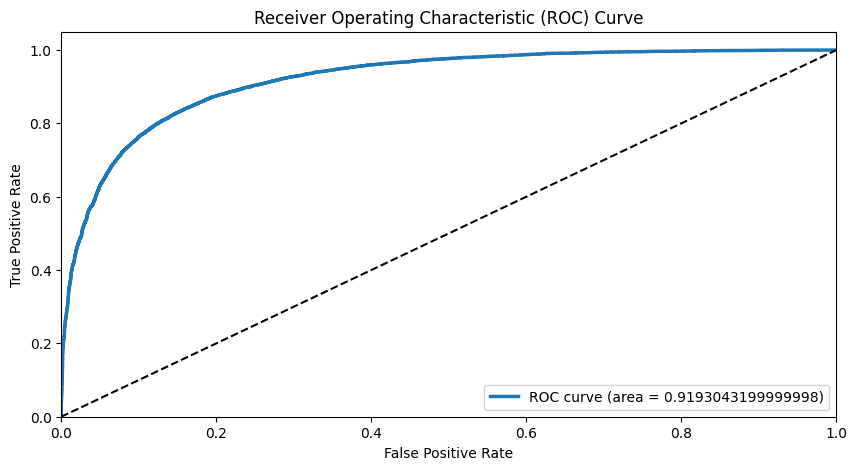

In [59]:
roc_auc=evaluation.plot_roc(log_reg_grid, y_test, X_test_vec)

In [60]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Model is not good enough!')
        
check_roc(roc_auc)

ValueError: Your model is not good enough!

Results from the LightGBM. This is good enough

In [78]:
evaluation.get_performance(lgbm_grid.predict(X_test_vec),y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.87204
Precision: 0.8719507318243621
Recall: 0.87216
F1 Score: 0.8720553533575972

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10899   1601
1   1598  10902


(0.87204, 0.8719507318243621, 0.87216, 0.8720553533575972)

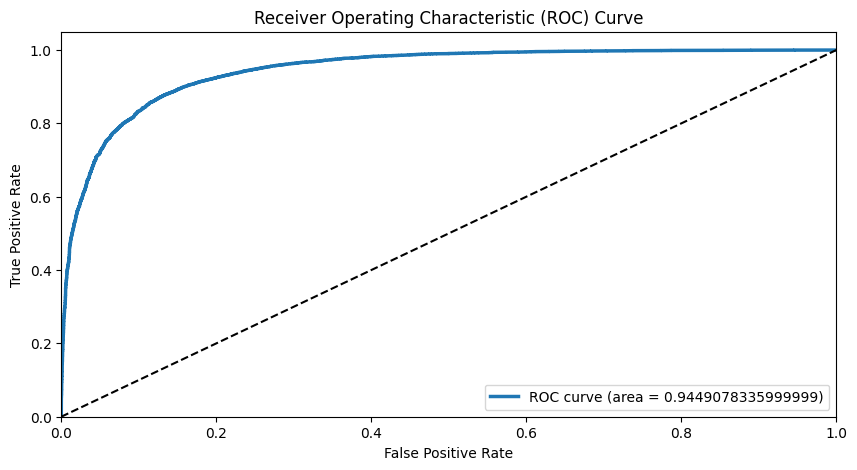

In [61]:
roc_auc=evaluation.plot_roc(lgbm_grid, y_test, X_test_vec)

In [62]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train a Word Embedding

For this I'll use the __gensim__ library. 

[Here](https://radimrehurek.com/gensim/models/word2vec.html) Gensim's Word2Vec documentation

As a previous step to training the word embedding the corpus must be tokenized

In [138]:
tokenizer = ToktokTokenizer()

In [137]:
def tokenize_corpus(corpus):
    text=[]
    for review in (corpus):
        text.append(tokenizer.tokenize(review))
    return text

In [139]:
X_train_norm_tok=tokenize_corpus(X_train_norm)
X_test_norm_tok=tokenize_corpus(X_test_norm)

In [140]:
len(X_train_norm_tok)

25000

In [237]:
X_test_norm[67]

'this be a great tv miniserie of a classic novel janet mcteer and john bowe in the lead role be exceptional this be one of the good adaptation from a book that i have see i would love to get a copy of this let i know if you know how i might get one thank'

In [148]:
X_test_norm_tok[67]

['this',
 'be',
 'a',
 'great',
 'tv',
 'miniserie',
 'of',
 'a',
 'classic',
 'novel',
 'janet',
 'mcteer',
 'and',
 'john',
 'bowe',
 'in',
 'the',
 'lead',
 'role',
 'be',
 'exceptional',
 'this',
 'be',
 'one',
 'of',
 'the',
 'good',
 'adaptation',
 'from',
 'a',
 'book',
 'that',
 'i',
 'have',
 'see',
 'i',
 'would',
 'love',
 'to',
 'get',
 'a',
 'copy',
 'of',
 'this',
 'let',
 'i',
 'know',
 'if',
 'you',
 'know',
 'how',
 'i',
 'might',
 'get',
 'one',
 'thank']

In [143]:
model_w2v = Word2Vec(X_train_norm_tok,vector_size=100, window=10, min_count=1, workers=16)


In [147]:
model_w2v.wv.most_similar(positive='cast')

[('actor', 0.6967448592185974),
 ('performer', 0.6632664799690247),
 ('ensemble', 0.6589738130569458),
 ('casting', 0.6297762393951416),
 ('support', 0.6139846444129944),
 ('performance', 0.5969241261482239),
 ('role', 0.584975004196167),
 ('chemistry', 0.5616539716720581),
 ('talent', 0.546952486038208),
 ('player', 0.5424289107322693)]

### Generate averaged word vector features

The embedding will convert each word into a vector of a given dimension (in this case $vector\_size=100$). 

The function has the following form:
* `vectorizer(corpus, model, num_features=100)`

Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [253]:
def vectorizer(corpus, model, num_features=100):
    vocabulary = model.wv.index_to_key
    corpus_vectors = []
    for doc in corpus:
        doc_vec=[]
        for w in doc:
            if w in vocabulary:
                word_vector=model.wv[w]
            else:
                word_vector=np.zeros((num_features),dtype="float32")
            doc_vec.append(word_vector)
        avg_vec=np.add.reduce(doc_vec)/len(doc_vec)
        corpus_vectors.append(avg_vec)
    return corpus_vectors

In [259]:
X_test_w2vec=vectorizer(X_test_norm_tok, model_w2v, num_features=100)
X_train_w2vec=vectorizer(X_train_norm_tok, model_w2v, num_features=100)

In [257]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.6228795647621155


In [1]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

NameError: name 'model_w2v' is not defined

### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [297]:
lgbmClass_w2v = lgbm.LGBMClassifier(boosting_type='gbdt',  objective='binary', learning_rate=0.1, metric='auc',num_leaves=20,num_iterations=2500)

In [298]:
lgbmClass_w2v.fit(X_train_w2vec,y_train)

/home/manuelquiros/Documents/VENVS/sprint06/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(metric='auc', num_iterations=2500, num_leaves=20,
               objective='binary')

In [299]:
evaluation.get_performance(lgbmClass_w2v.predict(X_test_w2vec),y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.81176
Precision: 0.814731061217897
Recall: 0.80704
F1 Score: 0.8108672936259144

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     12500
           1       0.81      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10206   2294
1   2412  10088


(0.81176, 0.814731061217897, 0.80704, 0.8108672936259144)

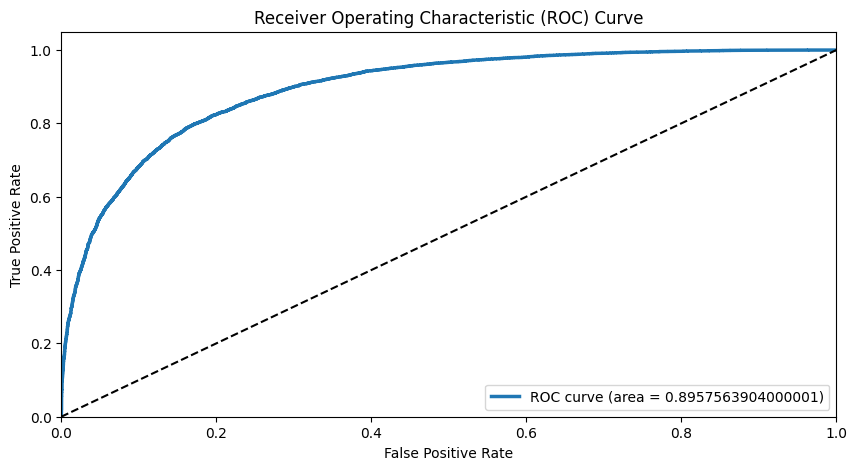

In [300]:
roc_auc=evaluation.plot_roc(lgbmClass_w2v, y_test, X_test_w2vec)

### *Don't change anything in this block, just make it run correctly*

In [275]:
#I know that the model is not good enough with word2vec but is common to get a lower value here compared to the tfidf vectorization 
#I don't want to loose more time here and be able to focus on the final project
check_roc(roc_auc)

ValueError: Your model is not good enough!